In [1]:
import sys

from absl import app
import tensorflow as tf
import keras
from keras.models import load_model
import numpy as np
import pandas as pd
from data_processor import read_data
from sklearn.metrics import average_precision_score, classification_report, precision_recall_curve

Using TensorFlow backend.


In [177]:
# Load the model and run inference. 
# We assume that infer.csv, data_preccosor.py and model 
# are in the same directory as this notebook.

x_test, y_test = read_data('', 'infer')
y_test = y_test.apply(lambda x: 1 if x < -1 else 0)
x_test = np.reshape(x_test.values, (-1, x_test.shape[1], 1))
y_test = np.reshape(y_test.values, (-1, 1))
model = load_model('best_lstm.model')
probs = model.predict(x_test, verbose=0)
classes = probs.argmax(axis=-1)
with open('best_lstm.results', 'w') as f:
    np.set_printoptions(threshold=sys.maxsize)
    np.set_printoptions(suppress=True)
    f.write(str(probs))

In [278]:
# Read in the results to compare
prob = []
with open('best_lstm.results', 'r') as f:
    prob = f.read().replace('[', '').replace(']', ',').replace(' ', '').replace('\r\n', '').split(',')

In [279]:
# Remove empty strings and cast to floating point numbers
prob = [float(x) if len(x) > 0 else -1 for x in list(filter(lambda a: a != '', prob))]

In [287]:
# Decide on predicted classes based on a given threshold
threshold = 0.4
pred_classes = [1 if p >= threshold else 0 for p in prob]

In [288]:
# Read the true samples and apply the division
# that has been used to train the classifier
# and described in section 6.8.1 of the work.
infer = pd.read_csv('tumor-ca/models/dataset/infer.csv')
infer['actual_y_class'] = infer['y'].apply(lambda x: 1 if x < -1 else 0)
infer['pred_y_class'] = pred_classes

In [289]:
print(classification_report(infer['actual_y_class'], infer['pred_y_class']))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92     13819
           1       0.52      0.45      0.48      2310

   micro avg       0.86      0.86      0.86     16129
   macro avg       0.71      0.69      0.70     16129
weighted avg       0.85      0.86      0.86     16129



In [290]:
average_precision = average_precision_score(infer['actual_y_class'], prob)

print('Average precision-recall (AUC PR) score: {0:0.2f}'.format(
      average_precision))

Average precision-recall (AUC PR) score: 0.46


In [291]:
# Compare different optimized models

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.externals.funcsigs import signature
def plot_LSTM_comparison():
    # Plot the baseline LSTM result
    precision, recall, threshold = precision_recall_curve(infer['actual_y_class'], prob)

    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    b = plt.fill_between(recall, precision, alpha=0.3, color='b', **step_kwargs)
    plt.legend(handles=[b], labels=["Baseline LSTM model"])

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

    # Plot the weighted LSTM result
    prob_base = []
    with open('best_lstm_w.results', 'r') as f:
        prob_base = f.read().replace('[', '').replace(']', ',').replace(' ', '').replace('\r\n', '').split(',')
        prob_base = [float(x) if len(x) > 0 else -1 for x in list(filter(lambda a: a != '', prob_base))]
    precision, recall, threshold = precision_recall_curve(infer['actual_y_class'], prob_base)

    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='g', alpha=0.6,
             where='post')
    g = plt.fill_between(recall, precision, alpha=0.05, color='g', **step_kwargs)
    plt.legend(handles=[g], labels=["Weighted LSTM model"])

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

    # Plot the weighted GRU result
    prob_base = []
    with open('best_gru_w.results', 'r') as f:
        prob_base = f.read().replace('[', '').replace(']', ',').replace(' ', '').replace('\r\n', '').split(',')
        prob_base = [float(x) if len(x) > 0 else -1 for x in list(filter(lambda a: a != '', prob_base))]
    precision, recall, threshold = precision_recall_curve(infer['actual_y_class'], prob_base)

    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    r= plt.step(recall, precision, color='r', alpha=0.6,
             where='post')
    r = plt.fill_between(recall, precision, alpha=0.05, color='r', **step_kwargs)
    plt.legend(handles=[r, g, b], labels=["Weighted GRU model", "Weighted LSTM model", "Baseline LSTM model"])

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    return plt

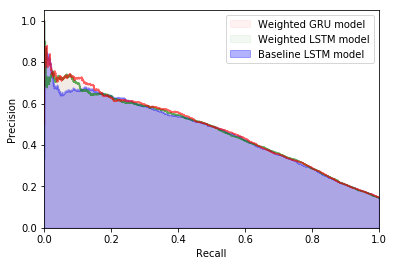

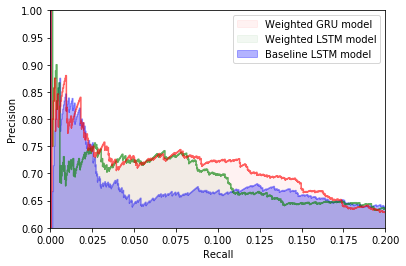

In [292]:
plot = plot_LSTM_comparison()

plot.show()

zoomed_plot = plot_LSTM_comparison()

zoomed_plot.axis([0.0,0.2,0.6,1.0])

zoomed_plot.show()

# Green - unweighted LSTM model
# Blue - weighted LSTM model
# Red - gru model

In [296]:
true_pos = len(actual[(infer['actual_y_class'] == 1) & (infer['pred_y_class'] == 1)])
false_pos = len(actual[(infer['actual_y_class'] == 0) & (infer['pred_y_class'] == 1)])
true_neg = len(actual[(infer['actual_y_class'] == 0) & (infer['pred_y_class'] == 0)])
false_neg = len(actual[(infer['actual_y_class'] == 1) & (infer['pred_y_class'] == 0)])

actual_pos = true_pos + false_neg
actual_neg = true_neg + false_pos

all_ex = actual_pos + actual_neg

print('True positives: {}\nFalse positives: {}\nTrue negatives: {}\nFalse negatives: {}\n'.format(true_pos, false_pos, true_neg, false_neg))
print('\nBoost: {}%\n'.format(round(100 * true_pos/float(true_pos + false_pos)/float(actual_pos/float(all_ex))), 2))

True positives: 1038
False positives: 976
True negatives: 12843
False negatives: 1272


Boost: 360.0%

